# CELL SEGMENTATION USING H&E STAINED IMAGES 

## Analyzing Dataset

In [1]:
import numpy as np # linear algebra
import tensorflow as tf
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil

In [2]:
import os
print(os.listdir("../New Work/"))

['.ipynb_checkpoints', 'base_dir', 'Cancer.ipynb', 'checkpoint.h5', 'finalized_model.sav', 'model.png', 'my_model.h5', 'sample_submission.csv', 'test', 'test.zip', 'train', 'train.zip', 'train_labels.csv']


In [3]:
# Total Samples Available
print('Train Images = ',len(os.listdir('../New Work/train')))
print('Test Images = ',len(os.listdir('../New Work/test')))

Train Images =  220025
Test Images =  57458


In [3]:
df = pd.read_csv('../New Work/train_labels.csv')
print('Shape of DataFrame',df.shape)
df.head()

Shape of DataFrame (220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
TRAIN_DIR = '../New Work/train/' 

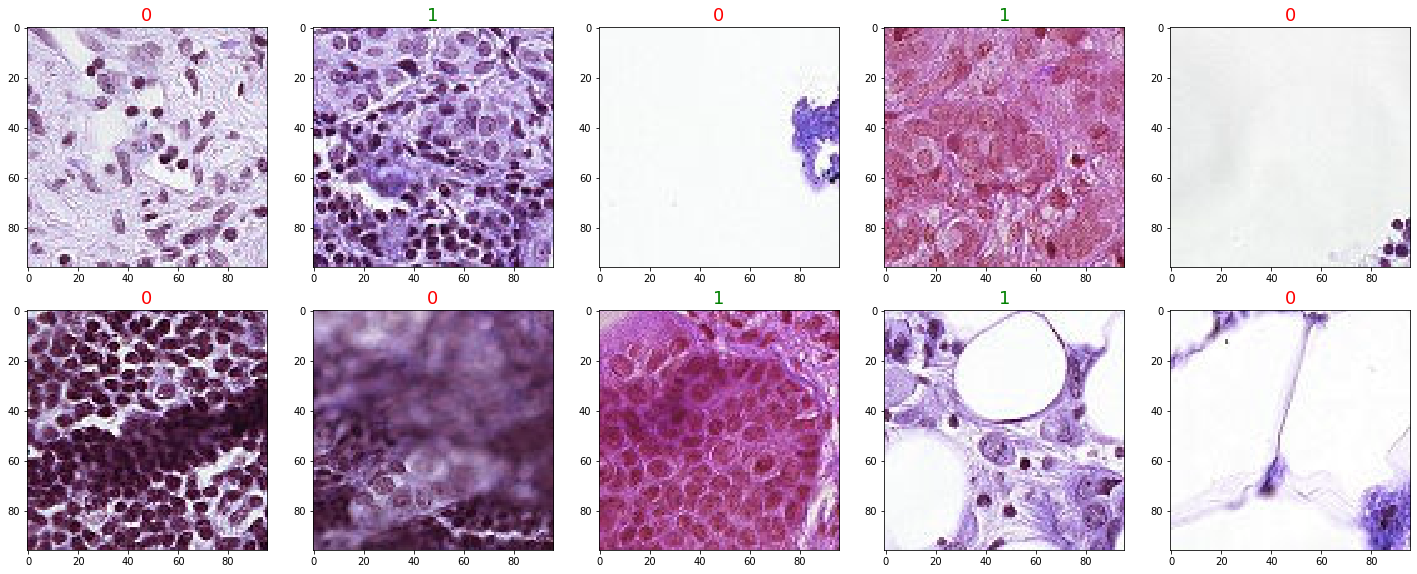

In [5]:
fig = plt.figure(figsize = (20,8))
index = 1
for i in np.random.randint(low = 0, high = df.shape[0], size = 10):
    file = TRAIN_DIR + df.iloc[i]['id'] + '.tif'
    img = cv2.imread(file)
    ax = fig.add_subplot(2, 5, index)
    ax.imshow(img, cmap = 'gray')
    index = index + 1
    color = ['green' if df.iloc[i].label == 1 else 'red'][0]
    ax.set_title(df.iloc[i].label, fontsize = 18, color = color)
plt.tight_layout()
plt.show()

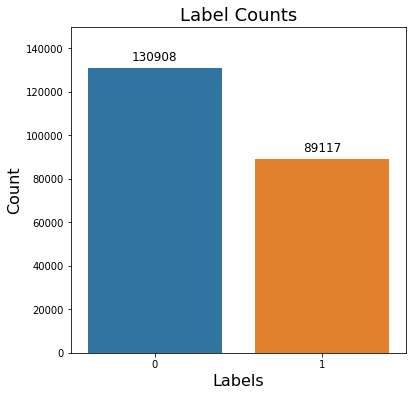

In [7]:
fig = plt.figure(figsize = (6,6)) 
ax = sns.countplot(df.label).set_title('Label Counts', fontsize = 18)
plt.annotate(df.label.value_counts()[0],
            xy = (0,df.label.value_counts()[0] + 2000),
            va = 'bottom',
            ha = 'center',
            fontsize = 12)
plt.annotate(df.label.value_counts()[1],
            xy = (1,df.label.value_counts()[1] + 2000),
            va = 'bottom',
            ha = 'center',
            fontsize = 12)
plt.ylim(0,150000)
plt.ylabel('Count', fontsize = 16)
plt.xlabel('Labels', fontsize = 16)
plt.show()

#### Here the Label-1 is 60% and Label-0 is 40% of the whole train images. There is a little imbalance here which we can rectify to get better performance.

# Feature Engineering

In [8]:
SAMPLE_SIZE = 80000
# take a random sample of class 0 with size equal to num samples in class 1
df_0 = df[df['label'] == 0].sample(SAMPLE_SIZE, random_state = 0)
# filter out class 1
df_1 = df[df['label'] == 1].sample(SAMPLE_SIZE, random_state = 0)

# concat the dataframes
df_train = pd.concat([df_0, df_1], axis = 0).reset_index(drop = True)
# shuffle
df_train = shuffle(df_train)

df_train['label'].value_counts()

1    80000
0    80000
Name: label, dtype: int64

### Split into Train and Validation Sets

In [9]:
# train_test_split
# stratify=y creates a balanced validation set.
y = df_train['label']

df_train, df_val = train_test_split(df_train, test_size = 0.1, random_state = 0, stratify = y)

### Put the two types of images into two folder to help Keras ImageGenerator


In [10]:
# Create a new directory
base_dir = 'base_dir'
#os.mkdir(base_dir)


#Folder Structure

'''
    * base_dir
        |-- train_dir
            |-- 0   #No Tumor
            |-- 1   #Has Tumor
        |-- val_dir
            |-- 0
            |-- 1
'''
# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
#os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
#os.mkdir(val_dir)

# create new folders inside train_dir
no_tumor = os.path.join(train_dir, '0')
#os.mkdir(no_tumor)
has_tumor = os.path.join(train_dir, '1')
#os.mkdir(has_tumor)


# create new folders inside val_dir
no_tumor = os.path.join(val_dir, '0')
#os.mkdir(no_tumor)
has_tumor = os.path.join(val_dir, '1')
#os.mkdir(has_tumor)


print(os.listdir('base_dir/train_dir'))
print(os.listdir('base_dir/val_dir'))

['0', '1']
['0', '1']


### Transfer the respective images into their respective folders

In [11]:
import shutil
# Set the id as the index in df_data

df = pd.read_csv('../New Work/train_labels.csv')

df.set_index('id',inplace= True)

# Get a list of train and val images
train_list = list(df_train['id'])

val_list = list(df_val['id'])

In [12]:
# DONT RUN THIS CODE SEGMENT TO BE EXECUTED ONCE
"""
# Transfer the train images

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    file_name = image + '.tif'
    # get the label for a certain image
    target = df.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = '0'
    elif target == 1:
        label = '1'
    
    # source path to image
    src = os.path.join('train', file_name)
    # destination path to image
    dest = os.path.join(train_dir, label, file_name)
    # copy the image from the source to the destination
    shutil.copyfile(src, dest)"""

"\n# Transfer the train images\n\nfor image in train_list:\n    \n    # the id in the csv file does not have the .tif extension therefore we add it here\n    file_name = image + '.tif'\n    # get the label for a certain image\n    target = df.loc[image,'label']\n    \n    # these must match the folder names\n    if target == 0:\n        label = '0'\n    elif target == 1:\n        label = '1'\n    \n    # source path to image\n    src = os.path.join('train', file_name)\n    # destination path to image\n    dest = os.path.join(train_dir, label, file_name)\n    # copy the image from the source to the destination\n    shutil.copyfile(src, dest)"

In [13]:
# DONT RUN THIS CODE SEGMENT TO BE EXECUTED ONCE
"""
# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    file_name = image + '.tif'
    # get the label for a certain image
    target = df.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = '0'
    elif target == 1:
        label = '1'
    

    # source path to image
    src = os.path.join('train', file_name)
    # destination path to image
    dest = os.path.join(val_dir, label, file_name)
    # copy the image from the source to the destination
    shutil.copyfile(src, dest)"""

"\n# Transfer the val images\n\nfor image in val_list:\n    \n    # the id in the csv file does not have the .tif extension therefore we add it here\n    file_name = image + '.tif'\n    # get the label for a certain image\n    target = df.loc[image,'label']\n    \n    # these must match the folder names\n    if target == 0:\n        label = '0'\n    elif target == 1:\n        label = '1'\n    \n\n    # source path to image\n    src = os.path.join('train', file_name)\n    # destination path to image\n    dest = os.path.join(val_dir, label, file_name)\n    # copy the image from the source to the destination\n    shutil.copyfile(src, dest)"

In [14]:
print(len(os.listdir('base_dir/train_dir/0')))
print(len(os.listdir('base_dir/train_dir/1')))

72000
72000


In [15]:
print(len(os.listdir('base_dir/val_dir/0')))
print(len(os.listdir('base_dir/val_dir/1')))

8000
8000


In [16]:
from keras.preprocessing.image import ImageDataGenerator
IMAGE_SIZE = 96
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = '../New Work/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 32 #10
val_batch_size = 32 #10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Using TensorFlow backend.


Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


## Create our Model (CancerNet)

In [17]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import SeparableConv2D
from keras.layers.core import Activation

In [18]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import tensorflow as tf
from tensorflow import keras
print(tf.version.VERSION)

2.1.0


In [19]:
!pip install -q pyyaml h5py

In [20]:
class Net:
    @staticmethod
    def build(width, height, depth, classes):
            
            #initializa model
            model = Sequential()
            
            inputShape = (height, width, depth)
            
            #Add First Layer CONV => ReLU => Pooling
            model.add(Conv2D(filters = 32, kernel_size = (5,5), padding="same", activation='relu', input_shape= inputShape))
            model.add(Conv2D(filters = 32, kernel_size = (3,3), padding="same", activation='relu'))
            model.add(Conv2D(filters = 32, kernel_size = (3,3), padding="same", activation='relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Dropout(0.2))
                      
            #Add Second Layer CONV => ReLU => Pooling
            model.add(Conv2D(filters = 64, kernel_size = (3,3), padding="same", activation='relu'))
            model.add(Conv2D(filters = 64, kernel_size = (3,3), padding="same", activation='relu'))
            model.add(Conv2D(filters = 64, kernel_size = (3,3), padding="same", activation='relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Dropout(0.2))
            
            #Add Third Layer CONV => ReLU => Pooling
            model.add(Conv2D(filters = 128, kernel_size = (3,3), padding="same", activation='relu'))
            model.add(Conv2D(filters = 128, kernel_size = (3,3), padding="same", activation='relu'))
            model.add(Conv2D(filters = 128, kernel_size = (3,3), padding="same", activation='relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Dropout(0.25))
            
            
            #FC => ReLU
            model.add(Flatten())
            model.add(Dense(units = 500, activation = 'relu'))
            model.add(Dropout(0.2))
            #FC => Output
            model.add(Dense(classes, activation='softmax'))
            
            model.summary()
            
            return model

In [21]:
class CancerNet:
    @staticmethod
    def build(width, height, depth, classes):
        
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
        # CONV => RELU => POOL
        model.add(SeparableConv2D(32, (3, 3), padding="same",input_shape = inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # (CONV => RELU => POOL) * 2
        model.add(SeparableConv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(SeparableConv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # (CONV => RELU => POOL) * 3
        model.add(SeparableConv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(SeparableConv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(SeparableConv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(256))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        model.summary()
 
        # return the constructed network architecture
        return model

### Specify optimizer and loss function



In [22]:
model = Net.build(width = 96, height = 96, depth = 3, classes = 2)
#model = CancerNet.build(width = 96, height = 96, depth = 3, classes = 2)

from keras.optimizers import SGD, Adam, Adagrad
#Edit:: Adagrad(lr=1e-2, decay= 1e-2/10) was used previous;y

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 48, 64)       

In [ ]:
# Dont execute 
model.compile(optimizer = Adam(lr=0.0001), loss = 'binary_crossentropy', metrics=['acc'])

## Visualize our model architecture

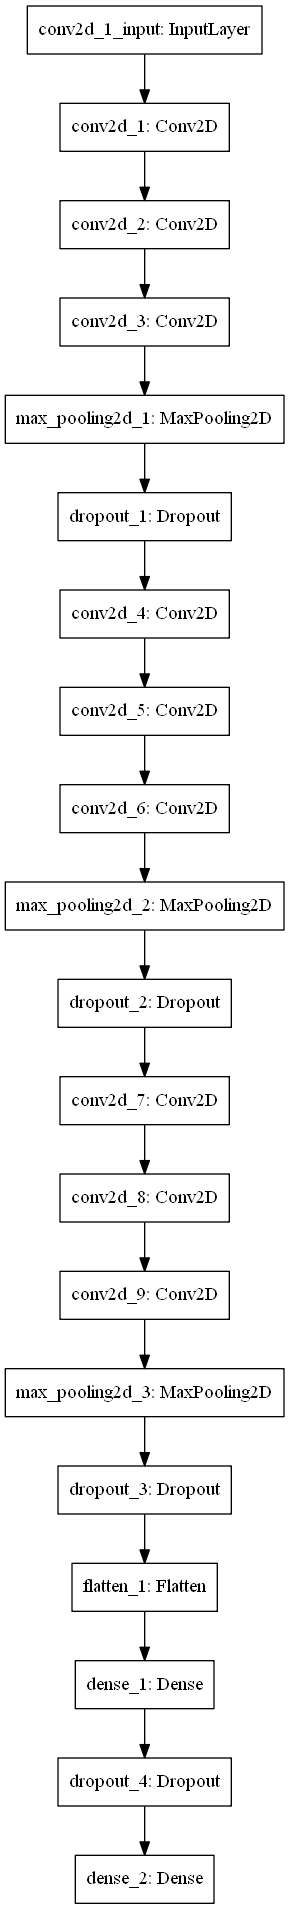

In [20]:
# Dont execute 

# Converts a Keras model to dot format and save to a file model.png.

from keras.utils import plot_model
plot_model(model, to_file='model.png')

# Model Training

### Define LR Scheduler and Save Model Checkpoint on Maximum Validation Accuracy


In [21]:
# Dont execute 

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
filepath1 = "checkpoint.h5"
checkpoint = ModelCheckpoint(filepath=filepath1, monitor='val_acc', verbose = 1, 
                             save_best_only = True, mode = 'max') #Save Best Epoch

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor = 0.5, patience = 2, verbose = 1, mode = 'max', min_lr = 0.00001)                              
callbacks_list = [checkpoint, reduce_lr] # LR Scheduler Used here

history = model.fit_generator(train_gen, steps_per_epoch = train_steps, 
                    validation_data = val_gen,
                    validation_steps = val_steps,
                    epochs = 11,
                    verbose = 1,
                    callbacks = callbacks_list)

Epoch 1/11
4500/4500 [==============================] - 6965s 2s/step - loss: 0.4392 - acc: 0.7959 - val_loss: 0.4986 - val_acc: 0.7944

Epoch 00001: val_acc improved from -inf to 0.79444, saving model to checkpoint.h5
Epoch 2/11
4500/4500 [==============================] - 6805s 2s/step - loss: 0.3478 - acc: 0.8478 - val_loss: 0.5286 - val_acc: 0.8460

Epoch 00002: val_acc improved from 0.79444 to 0.84600, saving model to checkpoint.h5
Epoch 3/11
4500/4500 [==============================] - 6864s 2s/step - loss: 0.2899 - acc: 0.8776 - val_loss: 0.3076 - val_acc: 0.8746

Epoch 00003: val_acc improved from 0.84600 to 0.87456, saving model to checkpoint.h5
Epoch 4/11
4500/4500 [==============================] - 6356s 1s/step - loss: 0.2548 - acc: 0.8950 - val_loss: 0.2231 - val_acc: 0.9066

Epoch 00004: val_acc improved from 0.87456 to 0.90656, saving model to checkpoint.h5
Epoch 5/11
4500/4500 [==============================] - 6729s 1s/step - loss: 0.2320 - acc: 0.9062 - val_loss: 0.41

In [24]:
'''from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpoint_path = "cp.h5"
#checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='val_acc', verbose = 1, 
                             save_best_only = True, mode = 'max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor = 0.5, patience = 2, verbose = 1, mode = 'max', min_lr = 0.00001)                              
callbacks_list = [cp_callback, reduce_lr] # LR Scheduler Used here

# Train the model with the new callback
history=model.fit(train_gen, steps_per_epoch = train_steps, 
                    validation_data = val_gen,
                    validation_steps = val_steps,
                    epochs = 1,
                    verbose = 1,
                    callbacks=callbacks_list)  # Pass callback to training'''

Epoch 1/1
 803/4500 [====>.........................] - ETA: 1:37:20 - loss: 0.5216 - accuracy: 0.7366

C:\Users\Chirayu\Anaconda3\lib\site-packages\keras\utils\data_utils.py:616: UserWarning: The input 1956 could not be retrieved. It could be because a worker has died.
  UserWarning)


4500/4500 [==============================] - 7362s 2s/step - loss: 0.4341 - accuracy: 0.8004 - val_loss: 0.5042 - val_accuracy: 0.8132


C:\Users\Chirayu\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


# Model Evaluation

## Compare Training and Validation Metrics¶



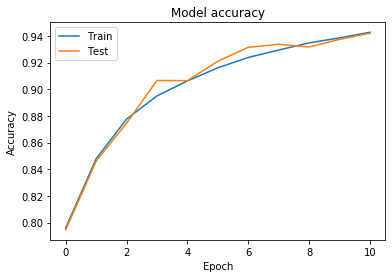

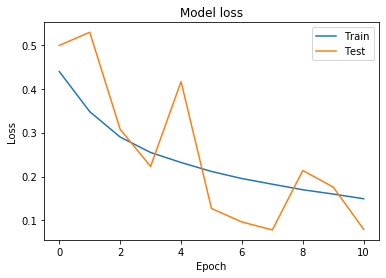

In [22]:
# Dont execute 

#  Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

### Load Weights

In [23]:
# execute from here
# Here the best epoch will be used.
model.load_weights('checkpoint.h5') 

val_loss, val_acc = model.evaluate_generator(test_gen, steps=len(df_val))
print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 0.0019564381800591946
val_acc: 0.942062497138977


In [24]:
#making predictions
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

16000/16000 [==============================] - 314s 20ms/step


In [36]:
# To be executed once
'''from keras.models import load_model 

model.save('my_model.h5')'''

In [25]:
# Put the predictions into a dataframe.
df_preds = pd.DataFrame(predictions, columns=['no_tumor', 'has_tumor'])
df_preds.head()

,no_tumor,has_tumor
0,0.997055,0.002945
1,0.979750,0.020250
2,0.975642,0.024358
3,0.979974,0.020026
4,0.997937,0.002063


In [26]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_tumor']

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
print('ROC AUC Score = ',roc_auc_score(y_true, y_pred))

ROC AUC Score =  0.9845551015625001


In [28]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

### ROC Curve

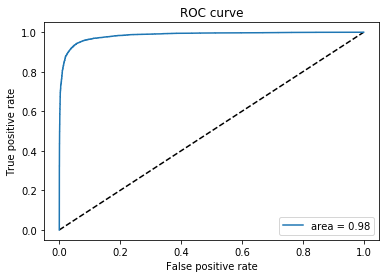

In [29]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.2f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

##### We are getting around 0.9 ROC AUC value, which is a quite good performance.



## Confusion Matrix

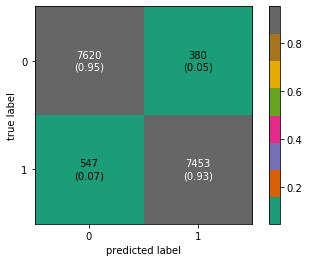

In [30]:
from sklearn.metrics import confusion_matrix
# For this to work we need y_pred as binary labels not as probabilities
y_pred_binary = predictions.argmax(axis=1)
cm = confusion_matrix(y_true, y_pred_binary)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                               cmap = 'Dark2')
plt.show()

## Classification Report

In [31]:
from sklearn.metrics import classification_report
# Generate a classification report

report = classification_report(y_true, y_pred_binary, target_names = ['no_tumor', 'has_tumor'])
print(report)

              precision    recall  f1-score   support

    no_tumor       0.93      0.95      0.94      8000
   has_tumor       0.95      0.93      0.94      8000

    accuracy                           0.94     16000
   macro avg       0.94      0.94      0.94     16000
weighted avg       0.94      0.94      0.94     16000



###### Recall = The classifier's ability to detect a given class. It is the number of correct positive results divided by the number of all relevant samples (all samples that should have been identified as positive).
###### Precision = Given a class prediction from a classifier, how likely is it to be correct? It is the number of correct positive results divided by the number of positive results predicted by the classifier.
###### F1 Score = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.

###### From the confusion matrix and classification report we see that our model is equally good at detecting both classes.



In [63]:
#Folder Structure

'''
    * test_dir
        |-- test_images
'''

# We will be feeding test images from a folder into predict_generator().

# create test_dir
test_dir = 'test_dir'
os.mkdir(test_dir)
    
# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)

# check that the directory we created exists
os.listdir('test_dir')

['test_images']

In [ ]:
'''# Transfer the test images into image_dir
test_list = os.listdir('../New Work/test')

for image in test_list:    
    fname = image
    # source path to image
    src = os.path.join('../New Work/test', fname)
   
    # destination path to image
    dst = os.path.join(test_images, fname)
    
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
print('Total Test Images = ',len(os.listdir('test_dir/test_images')))'''

In [94]:
test_path ='test_dir'
test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


In [99]:
num_test_images = 57458 #len(os.listdir('test_dir/test_images')

predictions = model.predict(test_gen, steps=num_test_images, verbose=1)
predictions

57458/57458 [==============================] - 2154s 37ms/step


array([[2.4273698e-03, 9.9757260e-01],
       [4.0342472e-03, 9.9596572e-01],
       [2.6875420e-03, 9.9731255e-01],
       ...,
       [9.9992406e-01, 7.5883399e-05],
       [5.0873935e-01, 4.9126062e-01],
       [8.2971925e-01, 1.7028075e-01]], dtype=float32)

In [102]:
if predictions.shape[0] == num_test_images:
    print('All Predictions Done!')
else:
    print('Error!')
    

All Predictions Done!


In [103]:
# Put the predictions into a dataframe
df_preds = pd.DataFrame(predictions, columns=['no_tumor', 'has_tumor'])
df_preds.head()

,no_tumor,has_tumor
0,0.002427,0.997573
1,0.004034,0.995966
2,0.002688,0.997313
3,0.572257,0.427743
4,0.998018,0.001982


In [112]:
# This outputs the file names in the sequence in which the generator processed the test images.
test_filenames = test_gen.filenames

# add the filenames to the dataframe
df_preds['file_names'] = test_filenames

# Create an id column
# A file name now has this format: 
# images/00006537328c33e284c973d7b39d340809f7271b.tif

# This function will extract the id:
# 00006537328c33e284c973d7b39d340809f7271b
def extract_id(x):
    
    # split into a list
    a = x.split('\\')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]
    
    return extracted_id

df_preds['id'] = df_preds['file_names'].apply(extract_id)

df_preds.head()


,no_tumor,has_tumor,file_names,id
0,0.002427,0.997573,test_images\00006537328c33e284c973d7b39d340809...,00006537328c33e284c973d7b39d340809f7271b
1,0.004034,0.995966,test_images\0000ec92553fda4ce39889f9226ace43ca...,0000ec92553fda4ce39889f9226ace43cae3364e
2,0.002688,0.997313,test_images\00024a6dee61f12f7856b0fc6be20bc7a4...,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,0.572257,0.427743,test_images\000253dfaa0be9d0d100283b22284ab2f6...,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,0.998018,0.001982,test_images\000270442cc15af719583a8172c87cd2bd...,000270442cc15af719583a8172c87cd2bd9c7746


In [113]:
# Get the predicted labels.
# We were asked to predict a probability that the image has tumor tissue
y_pred = df_preds['has_tumor']

# get the id column
image_id = df_preds['id']

### Preparing Submission Report

In [114]:
submission = pd.DataFrame({'id':image_id, 
                           'label':y_pred, 
                          }).set_index('id')

submission.to_csv('submission.csv', columns=['label'])

In [116]:
submission

,label
id,
00006537328c33e284c973d7b39d340809f7271b,0.997573
0000ec92553fda4ce39889f9226ace43cae3364e,0.995966
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.997313
000253dfaa0be9d0d100283b22284ab2f6b643f6,0.427743
000270442cc15af719583a8172c87cd2bd9c7746,0.001982
...,...
fffdd1cbb1ac0800f65309f344dd15e9331e1c53,0.000041
fffdf4b82ba01f9cae88b9fa45be103344d9f6e3,0.005911
fffec7da56b54258038b0d382b3d55010eceb9d7,0.000076
